# Denoising diffusion models

This is the main jupyter notebook for running the models for CIFAR10 and MNIST datasets.

### Imports

In [4]:
import torch
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import tqdm

from datetime import datetime
from torchvision import datasets, transforms

from diffusion_model import DiffusionModel
from dataset import DiffusionDataModule
from trainer import Trainer
from logger import Logger
from visualizer import Visualizer
from unet import SimpleModel
from typing import List
from schedule import LinearSchedule, CosineSchedule

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on: ", device)

Running on:  cuda


### Plotting functions

In [57]:
def denormalize_image(image: np.ndarray):
    '''
    Denormalize image from [-1, 1] to [0, 1]
    '''
    return (image + 1) / 2

def plot_forward_process(diffusion_model: DiffusionModel, x: torch.Tensor, t: List[int], 
                             title: str = 'Forward Process', cmap: str = 'gray', denormalize: bool = True):
    '''
    Plot the forward process of the diffusion model

    Inputs:
    - diffusion_model: Diffusion model
    - x: Single image as tensor [1, C, H, W]
    - t: List of time steps to plot
    - title: Title of the plot
    - cmap: Color map
    - denormalize: Denormalize the image before plotting
    '''
    # create plot
    fig, ax = plt.subplots(1, len(t), figsize=(10,4))
    for idx in range(len(t)):
        x_t = diffusion_model.forward(x, t[idx])
        x_t = x_t.permute(0, 2, 3, 1).detach().cpu().numpy()
        if denormalize:
            x_t = denormalize_image(x_t)
        x_t = np.clip(x_t, 0, 1)
        ax[idx].imshow(x_t[0], cmap=cmap)
        ax[idx].axis('off')
        ax[idx].set_title(f't={t[idx]}')
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_reverse_process(samples: List[np.ndarray], t: List[int], 
                             title: str = 'Reverse Process', cmap: str = 'gray', denormalize: bool = True):
    '''
    Plot the reverse process of the diffusion model

    Inputs:
    - samples: List of samples of shape [num_samples, C, H, W] corresponding to all time steps
    - t: List of time steps to plot
    - title: Title of the plot
    - cmap: Color map
    - denormalize: Denormalize the image before plotting
    '''
    # create plot
    fig, ax = plt.subplots(1, len(t), figsize=(10,6))
    for idx in range(len(t)):
        sample = np.transpose(samples[t[idx]][0],(1,2,0))
        if denormalize:
            sample = denormalize_image(sample)
        sample = np.clip(sample, 0, 1)
        ax[idx].imshow(sample, cmap=cmap)
        ax[idx].axis('off')
        ax[idx].set_title(f't={t[idx]}')
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_multiple_images(images: np.ndarray, 
                             title: str = 'Generated Images', cmap: str = 'gray', denormalize: bool = True):
    '''
    Plot multiple images in a grid

    Inputs:
    - images: numpy array of shape [B, C, H, W]. Shall be at least 5 images
    - title: Title of the plot
    - cmap: Color map
    - denormalize: Denormalize the image before plotting
    '''
    # preprocessing for plot
    if images.shape[0] > 16:
        images = images[:16]
        print('Only the first 16 images will be plotted')
    num_rows = int(np.ceil(images.shape[0] / 4))

    if denormalize:
        images = denormalize_image(images)

    images = np.clip(images, 0, 1)

    # create plot
    fig, ax = plt.subplots(num_rows, 4, figsize=(10,10))
    for i in range(num_rows):
        for j in range(4):
            if num_rows > 1:
                if i*4+j < images.shape[0]:
                    img = np.transpose(images[i*4+j],(1,2,0))
                    ax[i,j].imshow(img, cmap=cmap)
                ax[i,j].axis('off')
            else:
                if j < images.shape[0]:
                    img = np.transpose(images[j],(1,2,0))
                    ax[j].imshow(img, cmap=cmap)
                ax[j].axis('off')
    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

## MNIST

### Initialize the datasets

In [36]:
# Initialize data module & get data loaders
data_module = DiffusionDataModule()
train_loader_mnist, val_loader_mnist, test_loader_mnist = data_module.get_MNIST_data_split(
    batch_size=128,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

### Initialize the  best performing model for MNIST which was with Attention blocks and a Cosine schedule

In [37]:
model_path = os.path.join(os.path.dirname(os.getcwd()), "results", "mnist", "cosine", "attention", "2024-12-02_10-24-35-poster", "2024-12-02_01-34-47-DiffusionModel", "2024-12-02_01-34-47-DiffusionModel.pth")
print(model_path)

c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\results\mnist\cosine\attention\2024-12-02_10-24-35-poster\2024-12-02_01-34-47-DiffusionModel\2024-12-02_01-34-47-DiffusionModel.pth


In [38]:
# Initialize diffusion model
T =1000 
model = SimpleModel(ch_layer0=64, out_ch=1, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[0,1,2], dropout=0.1, resamp_with_conv= True)
schedule = CosineSchedule(T)
diffusion_model = DiffusionModel(model, T=T, schedule=schedule, img_shape=(1, 28, 28))
diffusion_model.load(model_path)
model.to(device)

Model loaded from c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\results\mnist\cosine\attention\2024-12-02_10-24-35-poster\2024-12-02_01-34-47-DiffusionModel\2024-12-02_01-34-47-DiffusionModel.pth


SimpleModel(
  (temb_dense0): Linear(in_features=64, out_features=256, bias=True)
  (temb_dense1): Linear(in_features=256, out_features=256, bias=True)
  (conv_in): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ResNetBlock(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_proj): Linear(in_features=256, out_features=64, bias=True)
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): AttnBlock(
      (norm): GroupNorm(32, 64, eps=1e-05, affine=True)
      (q): Linear(in_features=64, out_features=64, bias=True)
      (k): Linear(in_features=64, out_features=64, bias=True)
      (v): Linear(in_features=64, out_features=64, bias=True)
      (proj_out): Linear(in_featu

### Plot the forward process

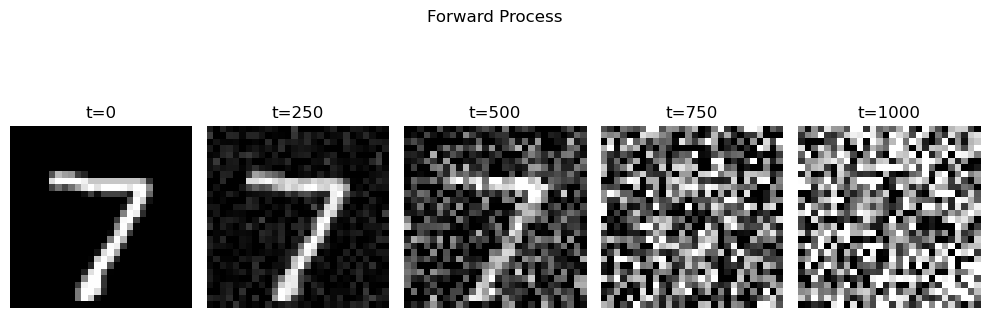

In [43]:
# Plot the samples
x, _ = next(iter(test_loader_mnist))
plot_forward_process(diffusion_model, x, [0, T//4, T//2, T*3//4, T], title='Forward Process', cmap='gray', denormalize=True)

### Plot reverse process

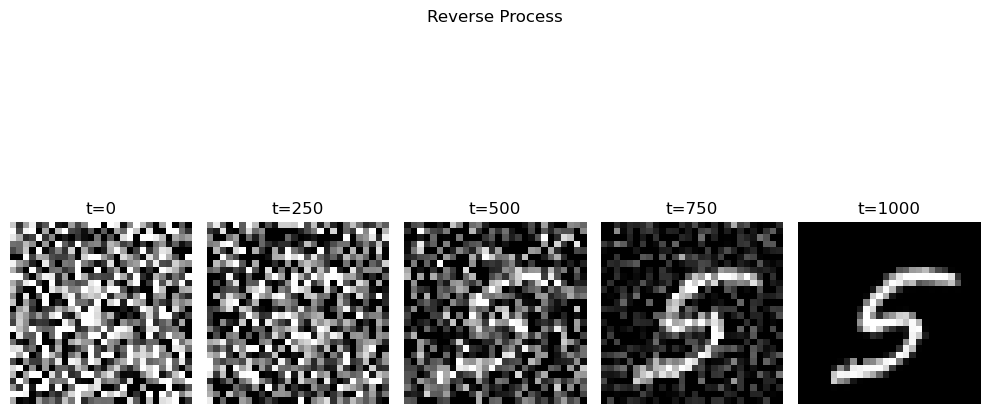

In [47]:
samples = diffusion_model.all_step_sample(n_samples=4)
plot_reverse_process(samples, [0, T//4, T//2, T*3//4, T], title='Reverse Process', cmap='gray', denormalize=True)

### Generate some image samples

c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\src\diffusion_model.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_dash_t = torch.tensor(self.schedule.alpha_dash(t)).detach()
c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\src\diffusion_model.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_t = torch.tensor(self.schedule.alpha(t)).detach()
c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\src\diffusion_model.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

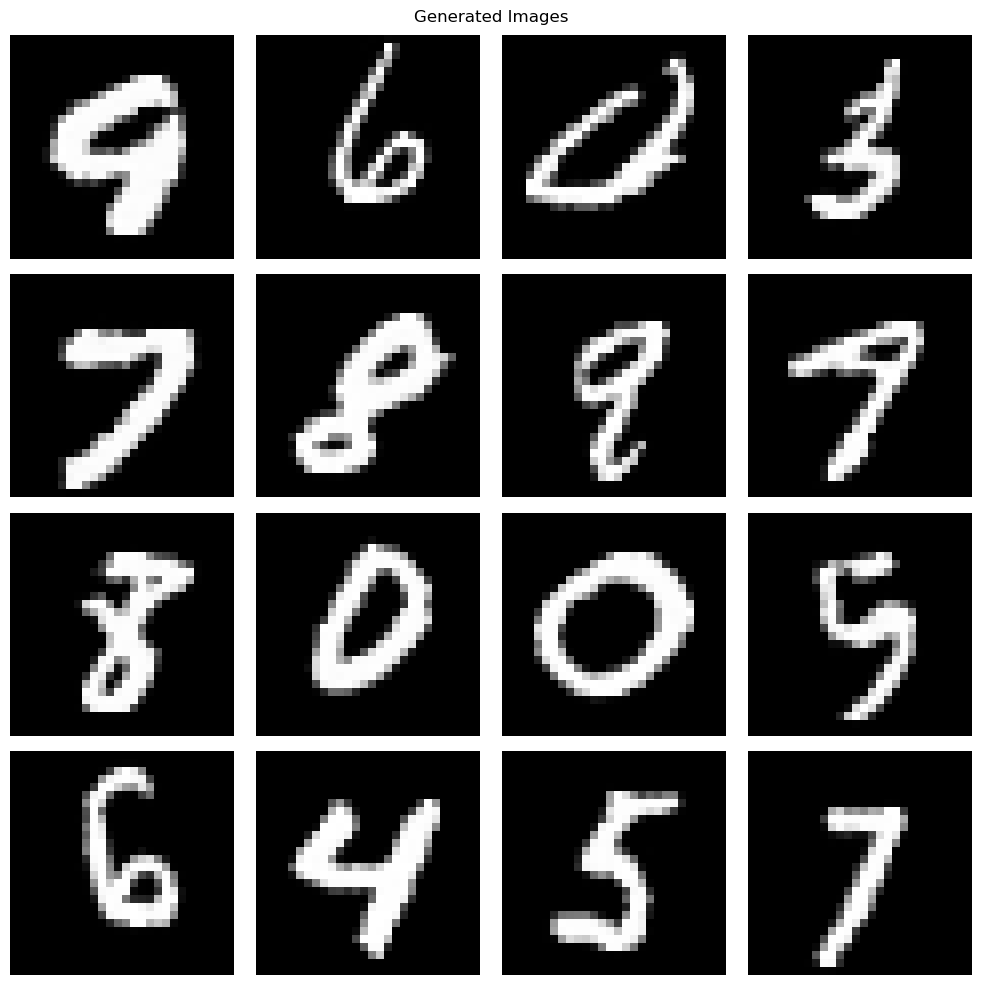

In [49]:
# Sample from the model
samples = diffusion_model.sample(n_samples=16)
plot_multiple_images(samples, title='Generated Images', cmap='gray', denormalize=True)

## CIFAR10

### Initialize the datasets

In [50]:
train_loader, val_loader, test_loader = data_module.get_CIFAR10_data_split(
    batch_size=128,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
)

Files already downloaded and verified
Files already downloaded and verified


### Initialize the  best performing model for CIFAR10 which was with no Attention blocks and a Linear schedule

In [52]:
model_path = os.path.join(os.path.dirname(os.getcwd()), "results", "cifar10", "linear", "noattention", "2024-12-02_19-45-40", "2024-12-02_10-22-05-DiffusionModel.pth")
print(model_path)

c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\results\cifar10\linear\noattention\2024-12-02_19-45-40\2024-12-02_10-22-05-DiffusionModel.pth


In [53]:
# Initialize diffusion model
T =1000 
model = SimpleModel(ch_layer0=64, out_ch=3, num_layers=3, num_res_blocks_per_layer=2, layer_ids_with_attn=[], dropout=0.1, resamp_with_conv= True)
schedule = LinearSchedule(10e-4, 0.02, T)
diffusion_model = DiffusionModel(model, T=T, schedule=schedule, img_shape=(3, 32, 32))
diffusion_model.load(model_path)
model.to(device)

Model loaded from c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\results\cifar10\linear\noattention\2024-12-02_19-45-40\2024-12-02_10-22-05-DiffusionModel.pth


SimpleModel(
  (temb_dense0): Linear(in_features=64, out_features=256, bias=True)
  (temb_dense1): Linear(in_features=256, out_features=256, bias=True)
  (conv_in): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0-1): 2 x ResNetBlock(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_proj): Linear(in_features=256, out_features=64, bias=True)
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Downsample(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3-4): 2 x ResNetBlock(
      (norm1): GroupNorm(64, 128, eps=1e-05, affine=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (temb_

### Plot the forward process

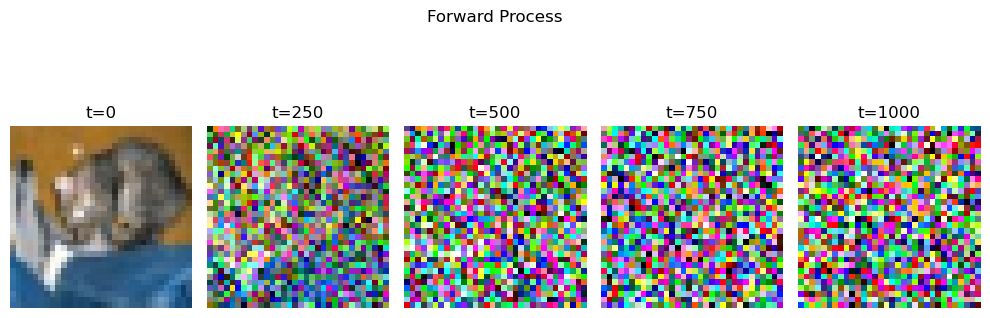

In [54]:
# Plot the samples
x, _ = next(iter(test_loader))
plot_forward_process(diffusion_model, x, [0, T//4, T//2, T*3//4, T], title='Forward Process', cmap=None, denormalize=True)

### Plot the reverse process

c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\src\diffusion_model.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_dash_t = torch.tensor(self.schedule.alpha_dash(t)).detach()
c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\src\diffusion_model.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_t = torch.tensor(self.schedule.alpha(t)).detach()
c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\src\diffusion_model.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

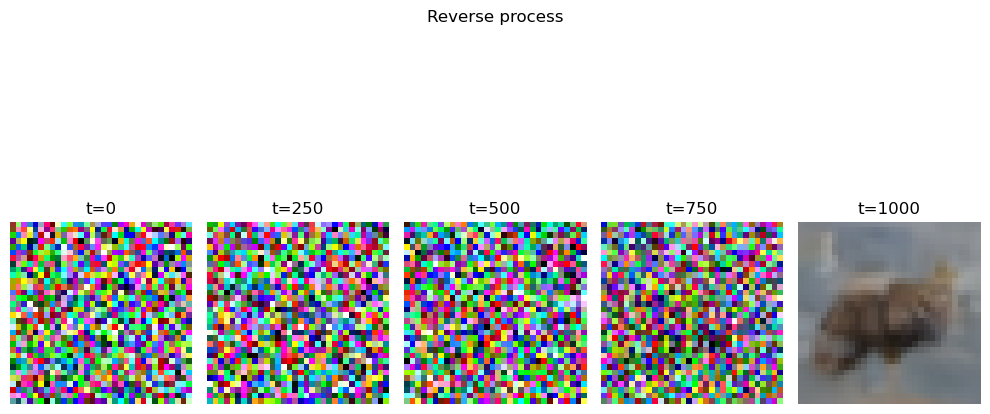

In [55]:
samples = diffusion_model.all_step_sample(n_samples=4)
plot_reverse_process(samples, [0, T//4, T//2, T*3//4, T], title="Reverse process", cmap=None, denormalize=True)

### Generate some image samples

c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\src\diffusion_model.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_dash_t = torch.tensor(self.schedule.alpha_dash(t)).detach()
c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\src\diffusion_model.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_t = torch.tensor(self.schedule.alpha(t)).detach()
c:\Users\zeljk\Documents\DTU\DeepLearning\DenoisingDiffusionModels\02456_Group_44_DDPM_Project\src\diffusion_model.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

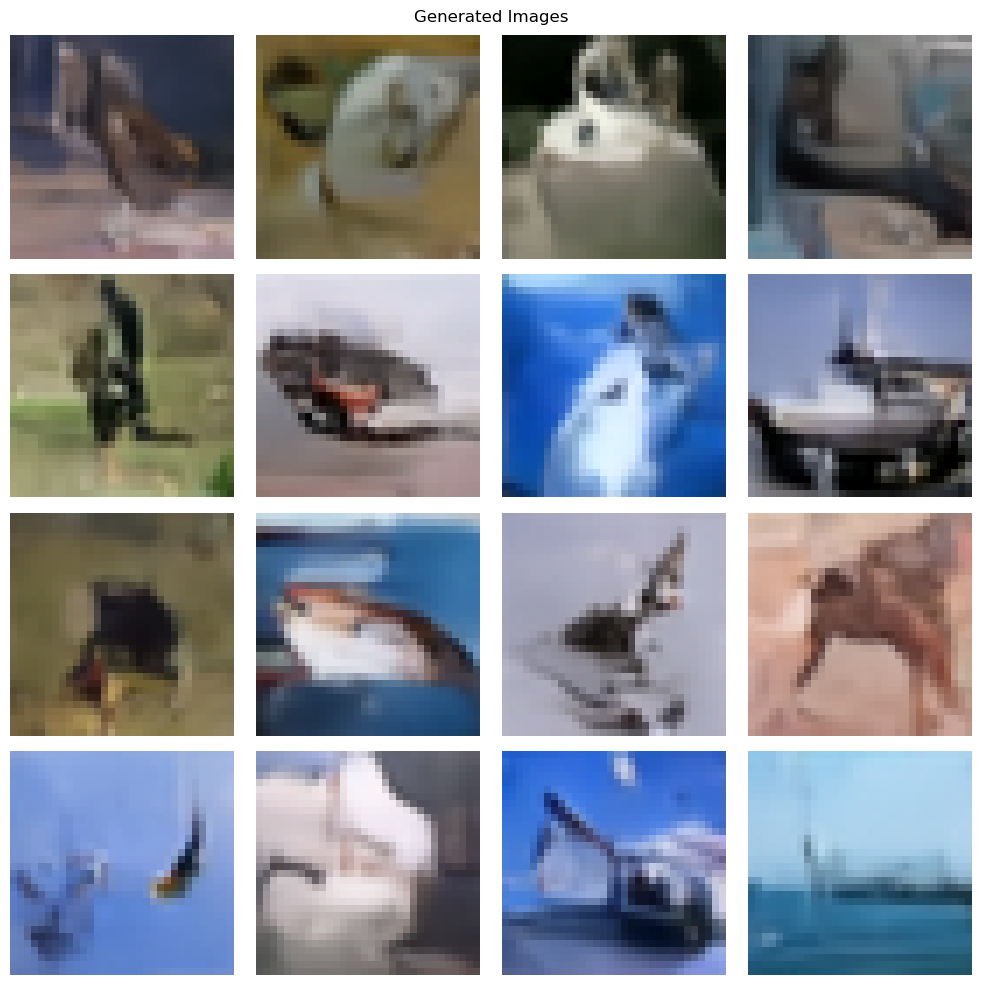

In [56]:
# Sample from the model
samples = diffusion_model.sample(n_samples=16)
plot_multiple_images(samples, title='Generated Images', cmap=None, denormalize=True)